<span style="color:red">Abgegeben von (Name, Vorname):</span> 
**Elsherif, Mohamed**

In [1]:
import nltk

Immer griffbereit:
- Website: https://www.nltk.org/
- Buch: https://www.nltk.org/book/
- Module: https://www.nltk.org/py-modindex.html
- Beispiele: http://www.nltk.org/howto/

<br>
<font size="6"><strong>8. Sitzung: Chunking und Hidden-Markov-Modelle</strong></font>
<br>

Zu wissen, was in einem Text die Sätze und Worte (qua Tokenisierung) und die POS-Tags der Worte (qua POS-Tagging) sind, reicht natürlich oft nicht aus, um etwas Sinnvolles über den Inhalt des Textes sagen können. Wenn wir nur das Nomen *York* sehen, wissen wir noch nicht, ob [York](https://de.wikipedia.org/wiki/York) oder [New York](https://de.wikipedia.org/wiki/New_York_City) gemeint ist. 

Das **Chunking** ist eine Methode, um größere, wortübergreifende Einheiten in einem Satz zu identifizieren. Dies ist ein wichtiger Vorverarbeitungsschritt z.B. für das Erkennen von Eigennamen aka. Named-Entity Recognition, mit der wir uns im nächsten Notebook beschäftigen werden.

In diesem Notebook werden grundlegende Konzepte und Verfahren des Chunkings vorgestellt, insbesondere **Hidden-Markov-Modelle (HMM)**.

# Was ist Chunking?

Unter Chunking versteht man die **überschneidungsfreie Gruppierung von benachbarten Wordtoken aufgrund ihres POS-Tags**. Zum Beispiel können Artikel, Adjektive und Nomen zu einem Chunk mit dem Label `NP` (für Nominalphrase) zusammengefasst werden:

<img src="https://www.nltk.org/images/chunk-segmentation.png" alt="Drawing"/>

## Klammernotation

Chunks werden üblicherweise mittels einer **Klammernotation** aufgeschrieben, z.B. so: 

    (CHUNK-TAG (POS-TAG1 wordform1) (POS-TAG2 wordform2) ...)
    
Also können wir obiges Beispiel folgendermaßen aufschreiben (und fügen dabei den Satz-Chunk hinzu):

    (S
      (NP (PRP We))
      (VBD saw)
      (NP (DT the) (JJ yellow) (NN dog))

## Nicht rekursiv!

Chunks können nicht nur Wortoken sondern auch Chunks enthalten. Dabei ist aber zu beachten, dass Chunks hinsichtlich des Labels **nicht rekursiv** sind! Das bedeutet beipielsweise, dass ein NP-Chunk kein anderes NP-Chunk enthalten darf.

Also **nicht** so:

    (S
      (NP (PRP We))
      (VBD saw)
      (NP (DT the) (JJ yellow) (NN dog)
        (PP (IN of                           # PP = Präpositionalphrase
          (NP (DT the) (NN neighbor))))))    # NP-Chunk in einem NP-Chunk: Das geht nicht! 
       

   
Sondern so: 

    (S
      (NP (PRP We))
      (VBD saw)
      (NP (DT the) (JJ yellow) (NN dog))
      (PP (IN of                           
          (NP (DT the) (NN neighbor)))))    # NP-Chunk in einem PP-Chunk: Das geht! 

Oder noch flacher:

    (S
      (NP (PRP We))
      (VBD saw)
      (NP (DT the) (JJ yellow) (NN dog))
      (PP (IN of))                           
      (NP (DT the) (NN neighbor)))
      
Man nennt das Chunking deshalb auch **Shallow Parsing**, weil die resultierenden Bäume flacher sind als beim "tiefen" Parsen (zu dem wir vielleicht in einem späteren Notebook kommen werden). 

## Baumdiagramme

Man kann übrigens mittels der NLTK-Klasse [`Tree`](https://www.nltk.org/api/nltk.tree.html?highlight=tree#nltk.tree.Tree) solche Klammerausdrücke leicht einlesen, verändern und wieder ausgeben: 

In [2]:
from nltk.tree import Tree

chunked_sent = "(S (NP (PRP We)) (VBD saw) (NP (DT the) (JJ yellow) (NN dog)  (PP (IN of) (NP (DT the) (NN neighbor)))))"
cs_tree = Tree.fromstring(chunked_sent)

print(cs_tree)            # Print mit Klammernotation
cs_tree.pretty_print()    # Pretty-Print mit Baum
print(cs_tree.leaves())   # Blätter des Baums
# cs_tree.draw()          # öffnet ein eigenes Fenter mit Baumdarstellung

(S
  (NP (PRP We))
  (VBD saw)
  (NP
    (DT the)
    (JJ yellow)
    (NN dog)
    (PP (IN of) (NP (DT the) (NN neighbor)))))
              S                            
  ____________|_____                        
 |   |              NP                     
 |   |    __________|_______                
 |   |   |    |     |       PP             
 |   |   |    |     |    ___|___            
 NP  |   |    |     |   |       NP         
 |   |   |    |     |   |    ___|_____      
PRP VBD  DT   JJ    NN  IN  DT        NN   
 |   |   |    |     |   |   |         |     
 We saw the yellow dog  of the     neighbor

['We', 'saw', 'the', 'yellow', 'dog', 'of', 'the', 'neighbor']


Der Baum kann z.B. in die binäre [Chomsky-Normalform](https://de.wikipedia.org/wiki/Chomsky-Normalform) umgewandelt werden:

In [3]:
cs_tree.chomsky_normal_form()
cs_tree.pretty_print()

     S                                                                 
  ___|______                                                            
 |      S|<VBD-NP>                                                     
 |    ______|______________                                             
 |   |                     NP                                          
 |   |       ______________|________                                    
 |   |      |                 NP|<JJ-NN-PP>                            
 |   |      |         ______________|___________                        
 |   |      |        |                      NP|<NN-PP>                 
 |   |      |        |      ____________________|_______                
 |   |      |        |     |                            PP             
 |   |      |        |     |         ___________________|___            
 NP  |      |        |     |        |                       NP         
 |   |      |        |     |        |                    _

# Was ist ein Chunk? Und was nicht?

Chunks sind Einheiten, die sich irgendwie "sinnvoll" von ihrer Umgebung abgrenzen lassen. Tatsächlich wird nie wirklich definitiert, was "sinnvoll" bedeutet. Man orientiert sich hier stattdessen an der **Konstituenten- oder Phrasenstruktur** und flacht diese nach bestimmten Regeln ab.

**Beispiel:** Eine Konstituentestruktur ist oft rekursiv und sieht z.B. so aus:

    (S
      (NP (PRP We))
      (VBD saw)
      (NP (DT the) (JJ yellow) (NN dog)
        (PP (IN of                      
          (NP (DT the) (NN neighbor))))))

Diese Konstituentenstruktur könnte z.B. **abgeflacht** werden, indem die NP und die PP (Präpositionalphrase) aus der komplexen NP herausgenommen und "angehoben" werden:

    (S
      (NP (PRP We))
      (VBD saw)
      (NP (DT the) (JJ yellow) (NN dog))
      (PP (IN of))                           
      (NP (DT the) (NN neighbor)))

Während die Konstituentstruktur in der Linguistik anhand sogenannter [**Konstituententests**](https://de.wikipedia.org/wiki/Konstituententest) (auf die wir hier nicht im Detail eingehen wollen) motiviert wird, gibt es solche linguistischen Tests für Chunks meines Wissens nicht. 

Stattdessen heiligt der Zweck die Struktur, nämlich zum Beispiel die **Nützlichkeit für Tasks wie die Named-Entity Recognition** (siehe nächstes Notebook). Und dafür ist etwa wichtig, dass *New York* in einem Satz als Einheit erkannt wird. 

# Methoden für das automatische Chunking

Sofern Chunks keine anderen Chunks einbetten, enthält ein Satz mit $n$ Worten maximal $n+1$ Chunks (inklusive Satz-Chunk), aber es gibt $2^{(n-1)}$ mögliche Chunking-Analysen. D.h. ein durchschnittlicher Satz ($n =20$) kann auf 524288 Arten gechunkt werden.  Es stellt sich also die Frage, wie man aus dieser Masse an möglichen Chunking-Analysen die richtige auswählt. 

## Vorbereitung der Trainings- und Testdaten

Für die Evaluierung der Methoden benötigen wir, ähnlich wie beim Tagging, disjunkte Trainings- und Testdaten mit Goldchunks. NLTK stellt hierfür mit `conll2000` das Chunk-Corpus des [CoNLL-2000-Shared-Task](https://aclanthology.org/W00-0726/) bereit. Es enthält 10.948 Sätze und 259.104 Worttoken, was sicherlich ausreichend ist. <span style="color:red">(Frage am Rande: Warum ist das wohl so?)</span>

In [4]:
nltk.download('conll2000')
from nltk.corpus import conll2000

[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\mel\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!


Für die Abfrage von `conll2000` stehen die üblichen Methoden zu Verfügung (`words()`, `sents()`, `tagged_words()`, ...). 

In [5]:
print(conll2000.sents()[0])

['Confidence', 'in', 'the', 'pound', 'is', 'widely', 'expected', 'to', 'take', 'another', 'sharp', 'dive', 'if', 'trade', 'figures', 'for', 'September', ',', 'due', 'for', 'release', 'tomorrow', ',', 'fail', 'to', 'show', 'a', 'substantial', 'improvement', 'from', 'July', 'and', 'August', "'s", 'near-record', 'deficits', '.']


### IOB-Notation

Zudem kann man das Corpus mit [`iob_words()`](https://www.nltk.org/api/nltk.corpus.reader.conll.html?highlight=iob_words#nltk.corpus.reader.conll.ConllCorpusReader.iob_words) und [`iob_sents`](https://www.nltk.org/api/nltk.corpus.reader.conll.html?highlight=iob_words#nltk.corpus.reader.conll.ConllCorpusReader.iob_sents) als Trippel bestehend aus Wortform, POS-Tag und Chunk-Tag ausgeben.

In [6]:
print(conll2000.iob_words()[:15])

[('Confidence', 'NN', 'B-NP'), ('in', 'IN', 'B-PP'), ('the', 'DT', 'B-NP'), ('pound', 'NN', 'I-NP'), ('is', 'VBZ', 'B-VP'), ('widely', 'RB', 'I-VP'), ('expected', 'VBN', 'I-VP'), ('to', 'TO', 'I-VP'), ('take', 'VB', 'I-VP'), ('another', 'DT', 'B-NP'), ('sharp', 'JJ', 'I-NP'), ('dive', 'NN', 'I-NP'), ('if', 'IN', 'B-SBAR'), ('trade', 'NN', 'B-NP'), ('figures', 'NNS', 'I-NP')]


Der Umfang der Chunks wird hier nicht mit Klammern, sondern mit Hilfe der **IOB-Annotation** ("Inside", "Outside", "Beginning") angezeigt. 
- `B-NP`: NP-Chunk beginnt an diesem Token
- `I-NP`: Token befindet sich in einem NP-Chunk, aber nicht am Anfang des NP-Chunks. 
- Das Ende des Chunks wird indirekt durch das nächste Worttoken markiert, dass mit `O` oder `B` annotiert ist. 

Ein Beispiel sieht so aus, wobei hier nur NP-Chunking durchgeführt wird:

<img src="https://www.nltk.org/images/chunk-tagrep.png" alt="Drawing"/>

Man beachte, dass hier das [POS-Tagset der Penn Treebank](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) verwendet wird. Will man das ändern, steht wie immer die Option `tagset` zur Verfügung.  

<span style="color:red">(Frage am Rande: Ist die IOB-Notation genauso ausdrucksstark wie die Klammernotation?)</span>

### Tree-Objekte

Neben der Tripel-Ausgabe kann man das Corpus mittels [`chunked_sents(chunk_types=None)`](https://www.nltk.org/api/nltk.corpus.reader.chunked.html?highlight=chunked_sents#nltk.corpus.reader.chunked.ChunkedCorpusReader.chunked_sents) auch als `Tree`-Objekte auslesen, wobei mit der Option `chunk_types` die Chunks anhand des Labels eingeschränkt werden können: 

In [7]:
print(conll2000.chunked_sents(chunk_types=None))

[Tree('S', [Tree('NP', [('Confidence', 'NN')]), Tree('PP', [('in', 'IN')]), Tree('NP', [('the', 'DT'), ('pound', 'NN')]), Tree('VP', [('is', 'VBZ'), ('widely', 'RB'), ('expected', 'VBN'), ('to', 'TO'), ('take', 'VB')]), Tree('NP', [('another', 'DT'), ('sharp', 'JJ'), ('dive', 'NN')]), ('if', 'IN'), Tree('NP', [('trade', 'NN'), ('figures', 'NNS')]), Tree('PP', [('for', 'IN')]), Tree('NP', [('September', 'NNP')]), (',', ','), ('due', 'JJ'), Tree('PP', [('for', 'IN')]), Tree('NP', [('release', 'NN')]), Tree('NP', [('tomorrow', 'NN')]), (',', ','), Tree('VP', [('fail', 'VB'), ('to', 'TO'), ('show', 'VB')]), Tree('NP', [('a', 'DT'), ('substantial', 'JJ'), ('improvement', 'NN')]), Tree('PP', [('from', 'IN')]), Tree('NP', [('July', 'NNP'), ('and', 'CC'), ('August', 'NNP')]), Tree('NP', [("'s", 'POS'), ('near-record', 'JJ'), ('deficits', 'NNS')]), ('.', '.')]), Tree('S', [('Chancellor', 'NNP'), Tree('PP', [('of', 'IN')]), Tree('NP', [('the', 'DT'), ('Exchequer', 'NNP')]), Tree('NP', [('Nigel',

Diese Ausgabe besteht aus verschachtelten `Tree`-Objekten, die jeweils einen Mutterknoten und die Töchterknoten umfassen.

D.h. wenn wir einen Satz auswählen, wird mit `print()` die Baumstruktur des `Tree`-Objekts besser lesbar ausgegeben:

In [8]:
print(conll2000.chunked_sents(chunk_types=None)[0])

(S
  (NP Confidence/NN)
  (PP in/IN)
  (NP the/DT pound/NN)
  (VP is/VBZ widely/RB expected/VBN to/TO take/VB)
  (NP another/DT sharp/JJ dive/NN)
  if/IN
  (NP trade/NN figures/NNS)
  (PP for/IN)
  (NP September/NNP)
  ,/,
  due/JJ
  (PP for/IN)
  (NP release/NN)
  (NP tomorrow/NN)
  ,/,
  (VP fail/VB to/TO show/VB)
  (NP a/DT substantial/JJ improvement/NN)
  (PP from/IN)
  (NP July/NNP and/CC August/NNP)
  (NP 's/POS near-record/JJ deficits/NNS)
  ./.)


### CoNLL-Format

Übrigens ist das "rohe" CoNLL-2000-Corpus im weitverbreiteten [**CoNLL-Format**](https://universaldependencies.org/docs/format.html) kodiert, bei dem jedes Wort und seine Tags eine Zeile bilden:

In [9]:
print(conll2000.raw()[:140])

Confidence NN B-NP
in IN B-PP
the DT B-NP
pound NN I-NP
is VBZ B-VP
widely RB I-VP
expected VBN I-VP
to TO I-VP
take VB I-VP
another DT B-NP


## Splits und MFC-Baseline

Praktischerweise sind die CoNLL-Daten bereits in Trainings- und Testdaten aufgeteilt:

In [10]:
conlltrain = conll2000.chunked_sents('train.txt')
conlltest = conll2000.chunked_sents('test.txt')

print("Verhältnis Testdaten/Trainingsdaten: ",
      len(conll2000.chunked_sents('test.txt'))/len(conll2000.chunked_sents('train.txt')))

Verhältnis Testdaten/Trainingsdaten:  0.2251566696508505


Vergleichbar mit dem POS-Tagging können wir uns erst einmal klar machen, wie schwer die Aufgabe ist, und eine einfache MFC-Baseline ("Most Frequent Chunk") bestimmen. Dafür schauen wir am besten auf die IOB-Annotation im rohen CoNLL2000-Corpus, da hier die einzelnen Wordtoken annotiert sind:

In [11]:
from nltk.probability import FreqDist

chunkdist = FreqDist(
    [chunktag for word, postag, chunktag in conll2000.iob_words('train.txt')])
mfc = chunkdist.most_common(1)[0][0]

chunkdist.most_common(20)

[('I-NP', 63307),
 ('B-NP', 55081),
 ('O', 27902),
 ('B-VP', 21467),
 ('B-PP', 21281),
 ('I-VP', 12003),
 ('B-ADVP', 4227),
 ('B-SBAR', 2207),
 ('B-ADJP', 2060),
 ('I-ADJP', 643),
 ('B-PRT', 556),
 ('I-ADVP', 443),
 ('I-PP', 291),
 ('I-CONJP', 73),
 ('I-SBAR', 70),
 ('B-CONJP', 56),
 ('B-INTJ', 31),
 ('B-LST', 10),
 ('I-INTJ', 9),
 ('I-UCP', 6)]

Das häufigste Chunk-Tag ist also `I-NP`. Im Trainingskorpus wird dieses Tag immerhin bei knapp 30% der Wordtoken verwendet:

In [12]:
100 * chunkdist.most_common(1)[0][1] / len(conll2000.iob_words('train.txt'))

29.900296136062003

Dies ist also auch unsere Accuracy-Baseline, d.h. ein sehr einfacher Chunker, der jedes Worttoken mit dem Tag `I-NP` versieht, erreicht eine Accuracy in dieser Höhe. Korrekterweise müssen wir diesen Wert anhand der Testdaten errechnen:

In [13]:
100 * FreqDist([chunktag for word, postag, chunktag in conll2000.iob_words('test.txt')]
               ).most_common(1)[0][1] / len(conll2000.iob_words('test.txt'))

30.34383772716719

Natürlich ist es noch **nicht einmal theoretisch brauchbar**, jedes Token mit `I-NP` zu taggen, weil das zu einem nicht wohlgeformten IOB-Muster führt. Es fehlt nämlich das initiale `B`-Tag. Trotzdem wollen wir der Vollständigkeit halber als erstes so einen Default-Chunker implementierten.  

## Default-Chunker

Ein Default-Chunker weist jedem Word dasselbe Chunk-Tag zu. NLTK bietet hierfür keine fertige Implementierung an; allerdings kann man dafür den [`DefaultTagger`](https://www.nltk.org/api/nltk.tag.sequential.html?highlight=defaulttagger#nltk.tag.sequential.DefaultTagger) aus der letzten Sitzung verwenden! Man muss dafür einfach POS-Tags wie Wortformen und Chunk-Tags wie POS-Tags behandeln:  

In [14]:
# Adapted from https://www.nltk.org/book/ch07.html
class DefaultChunker(nltk.ChunkParserI):
    def __init__(self, default):
        self.tagger = nltk.DefaultTagger(default)   # Benutze den DefaultTagger

    def parse(self, sentence):
        pos_tags = [pos for (word, pos) in sentence]
        # Die POS-Tags werden wie Wörter beim POS-Tagging verwendet.
        tagged_pos_tags = self.tagger.tag(pos_tags)

        # Bringe die Chunk-Tags in das richtige Ausgabeformat
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word, pos), chunktag)
                     in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)

Die Chunker-Klassen, die vom Interface [`ChunkParserI`](https://www.nltk.org/api/nltk.chunk.api.html#nltk.chunk.api.ChunkParserI) abgeleitet werden, haben eine Methode `accuracy(goldtestdata)`, mit der die Evaluation anhand von Goldtestdaten durchgeführt werden kann:

In [15]:
default_chunker = DefaultChunker('I-NP')
print(default_chunker.accuracy(conlltest))

ChunkParse score:
    IOB Accuracy:  33.2%%
    Precision:      0.7%%
    Recall:         0.1%%
    F-Measure:      0.1%%


Die "IOB Accuracy" liegt zwar in einem Bereich, den wir erwartet haben, aber die Werte für Precision, Recall und F-Measure wirken erst einmal seltsam, weil sie sich erheblich von der IOB Accuracy unterscheiden. Dies liegt an einer unterschiedlichen Bemessungsgrundlage:
- Die IOB Accuracy betrachtet jedes einzelnen Chunk-Tag. Da jedes Worttoken ein Chunk-Tag erhält, ist hier nur die Accuracy sinnvoll (bzw. äquivalent zu F1-Measure). Da relativ viele Worttoken das Chunk-Tag `I-NP` haben, ist die IOB Accuracy noch relativ hoch. 
- Precision, Recall und F1-Measure betrachten hier die Annotation ganzer Chunks. Da die Anzahl und der Umfang der Chunks nicht festgelegt ist, können sich Precision und Recall unterscheiden. Da keine `B-NP` verwendet werden, sind quasi gar keine Chunks annotiert und das F1-Measure dementsprechend sehr gering. <span style="color:red">(Frage am Rande: Sollte das F-Measure dann nicht eigentlich bei 0% liegen?)</span> 

## Regexp-Chunker

Wie beim POS-Tagging gibt es für das Chunkging ein regelbasiertes Verfahren mittels regulärer Ausdrücke. Dieses Verfahren benötigt keine Lerndaten, denn es können die Chunking-Regeln auf Grundlage der POS-Tags direkt angegeben werden.

Man unterscheidet vier Arten von Chunking-Regeln:
1. **Chunk:** Fasse die POS-Tags zu einem Chunk zusammen.
2. **Chink:** Entferne die POS-Tags aus einem Chunk.
3. **Split:** Teile das Chunk an einer bestimmten Stelle. 
4. **Merge:** Fasse zwei Chunks zusammen.

Die Reihenfolge der Regel-Typen kann beliebig festegelegt werden. Man kann zum Beispiel erst einen großen Chunk erstellen, diesen dann splitten, dann bestimmte Chunks chinken, dann wieder bestimmte Chunks mergen usw. 

Eine Regel beschreibt eine **Kette von POS- oder Chunk-Tags** mit Hilfe von regulären Operatoren:


| **REGEXP** | **Beschreibung**                                     |
| :-------   | :-------------------                                 |
| `<NN>`     | ein Worttoken mit dem POS-Tag `NN`                   |
| `<NN>+`    | ein oder mehr als ein Wordtoken mit dem POS-Tag `NN` |
| `<NN.?>`   | ein Worttoken mit dem POS-Tag `NN` oder `NNS` oder `NNP`        |
| `<NN\|AT>`   | ein Worttoken mit dem POS-Tag `NN` oder `AT`         |
| `<.*>`     | ein Wordtoken mit einem beliebigen POS-Tag           |
| `<VP><NP>` | eine Verbalphrase gefolgt von einer Nominalphrase |

Der Regel-Typ wird mit geschweiften Klammern angedeutet:

| **REGEXP**           | **Beschreibung** |
| :------------------- | :-------         |
| `{REGEXP}`           | Chunk            |
| `}REGEXP{`           | Chink            |
| `REGEXP}{REGEXP`    | Split            |
| `REGEXP{}REGEXP`     | Merge            |

Hier ein kleines Beispiel:

In [16]:
grammar = r"""
  NP:
    {<.*>+}          # Chunk everything
    }<VBD|IN|RP>+{   # Chink sequences of VBD, IN, RP
  VP: 
    {<VBD><.*>+}     # Chunk VBD and everything following it
    }<NP>{           # Chink NP chunks 
  """

Diese Grammatik ist die Eingabe für den [`RegexpParser`](https://www.nltk.org/api/nltk.chunk.regexp.html?highlight=regexpparser#nltk.chunk.regexp.RegexpParser), wobei mit `loop=1` die Anzahl der Durchläufe und mit `trace=1` der Grad der Protokollierung festgelegt werden kann.

In [17]:
regexp_chunker = nltk.RegexpParser(grammar, loop=1, trace=1)

sentence = [("Rapunzel", "NNP"), ("let", "VBD"), ("down", "RP"),
            ("her", "PP$"), ("long", "JJ"), ("golden", "JJ"), ("hair", "NN")]
print(regexp_chunker.parse(sentence))

# Input:
 <NNP>  <VBD>  <RP>  <PP$>  <JJ>  <JJ>  <NN> 
# Chunk everything:
{<NNP>  <VBD>  <RP>  <PP$>  <JJ>  <JJ>  <NN>}
# Chink sequences of VBD, IN, RP:
{<NNP>} <VBD>  <RP> {<PP$>  <JJ>  <JJ>  <NN>}
# Input:
 <NP>  <VBD>  <RP>  <NP> 
# Chunk VBD and everything following it:
 <NP> {<VBD>  <RP>  <NP>}
# Chink NP chunks:
 <NP> {<VBD>  <RP>} <NP> 
(S
  (NP Rapunzel/NNP)
  (VP let/VBD down/RP)
  (NP her/PP$ long/JJ golden/JJ hair/NN))


Die Performance ist aber insgesamt verbesserungsfähig ...

In [18]:
regexp_chunker = nltk.RegexpParser(grammar, loop=1)
print(regexp_chunker.accuracy(conlltest))

ChunkParse score:
    IOB Accuracy:  48.5%%
    Precision:     27.1%%
    Recall:        14.8%%
    F-Measure:     19.1%%


### <span style="color:red">Aufgaben I: Regexp-Chunker </span>

<span style="color:red">A1:</span> Überlegen Sie sich sinnvolle Chunking-Regeln und implementieren Sie diese als `mygrammar` wie oben als reguläre Ausdrücke! Führen Sie eine Evaluation mit `accuracy()` durch und erzielen Sie einen F1-Wert >=70!

In [19]:
# Lösung A1

loop_level = 1
trace_level = 0

## 61.1%
mygrammar = r"""
    NP: {<DT|PRP\$>?<JJ.*>*<NN.*>+}    # Noun phrases with determiners, adjectives, and nouns
        {<NNP.*>+<POS>?<NN.*>*}        # Proper noun phrases with optional possessive
        {<DT|PRP\$>?<CD>+}              # Numbers or numeric phrases
    VP: {<MD|VB.*><RB.*>*<VB.*>+}        # Modal or verb with optional adverb
        {<TO><VB>}                      # Infinitive phrases
        {<VP> <CC> <VP>}                # Coordination of verb phrases
        {<VB.*><RB.*>*<VB.*>*}          # Passive constructions with additional verbs
    PP: {<IN><DT|JJ|CD>?<NN.*>+}         # Prepositions with noun phrases
    PARENTH: {<,><NP|PP|VP|JJ>*<,>}     # Parenthetical elements
    NUM: {<\$>?<CD>+<NNS|NN>?}          # Numbers with units 
"""

In [20]:
# Test (nicht verändern)

my_regexp_chunker = nltk.RegexpParser(
    mygrammar, loop=loop_level, trace=trace_level)
print(my_regexp_chunker.accuracy(conlltest))

ChunkParse score:
    IOB Accuracy:  73.0%%
    Precision:     69.6%%
    Recall:        55.4%%
    F-Measure:     61.7%%


In [ ]:
# Generate confusion matrix

from nltk.metrics import ConfusionMatrix
from nltk import conlltags2tree, tree2conlltags

gold = [chunktag for word, tag, chunktag in conll2000.iob_words('test.txt')]
test = [chunktag for sent in conll2000.tagged_sents('test.txt')
        for word, tag, chunktag in tree2conlltags([tree for tree in my_regexp_chunker.parse(sent)])]

print(ConfusionMatrix(gold, test).pretty_format(show_percents=True,
      values_in_chart=True, truncate=15, sort_by_count=True))

In [21]:
# Inspect parsed data

index = 0 # <-- Change sentence here 
gold = conll2000.chunked_sents('train.txt')[index]
test = my_regexp_chunker.parse(conll2000.tagged_sents('train.txt')[index])

print("GOLD:")
print(gold)

print("\nTEST:")
print(test)

# Show the diff
print("\n==== Diff ====\n")

import io
import difflib
from contextlib import redirect_stdout

# Capture output of print(gold)
gold_output = io.StringIO()
with redirect_stdout(gold_output):
    print(gold)

# Capture output of print(test)
test_output = io.StringIO()
with redirect_stdout(test_output):
    print(test)

# Preprocess: Normalize lines to ignore indentation
def normalize_whitespace(text):
    return "\n".join(line.lstrip() for line in text.splitlines())
    
# Get the string values of the outputs
gold_text = normalize_whitespace(gold_output.getvalue())
test_text = normalize_whitespace(test_output.getvalue())

# Compare using difflib
diff = difflib.unified_diff(
    gold_text.splitlines(), 
    test_text.splitlines(), 
    lineterm="", 
    fromfile="Gold", 
    tofile="Test"
)

# Print the diff
print("\n".join(diff))


GOLD:
(S
  (NP Confidence/NN)
  (PP in/IN)
  (NP the/DT pound/NN)
  (VP is/VBZ widely/RB expected/VBN to/TO take/VB)
  (NP another/DT sharp/JJ dive/NN)
  if/IN
  (NP trade/NN figures/NNS)
  (PP for/IN)
  (NP September/NNP)
  ,/,
  due/JJ
  (PP for/IN)
  (NP release/NN)
  (NP tomorrow/NN)
  ,/,
  (VP fail/VB to/TO show/VB)
  (NP a/DT substantial/JJ improvement/NN)
  (PP from/IN)
  (NP July/NNP and/CC August/NNP)
  (NP 's/POS near-record/JJ deficits/NNS)
  ./.)

TEST:
(S
  (NP Confidence/NN)
  in/IN
  (NP the/DT pound/NN)
  (VP is/VBZ widely/RB expected/VBN)
  (VP to/TO take/VB)
  (NP another/DT sharp/JJ dive/NN)
  if/IN
  (NP trade/NN figures/NNS)
  for/IN
  (NP September/NNP)
  ,/,
  due/JJ
  for/IN
  (NP release/NN tomorrow/NN)
  ,/,
  (VP fail/VB)
  (VP to/TO show/VB)
  (NP a/DT substantial/JJ improvement/NN)
  from/IN
  (NP July/NNP)
  and/CC
  (NP August/NNP)
  's/POS
  (NP near-record/JJ deficits/NNS)
  ./.)

==== Diff ====

--- Gold
+++ Test
@@ -1,22 +1,26 @@
 (S
 (NP Confidence/

## N-Gram-Chunker

Genauso wie beim **POS-Tagging** kann man auch beim Chunking die Tags der $n-1$ vorangegangenen Worttoken nutzen und dementsprechend Unigram-, Bigram- und Trigram-Chunker entwickeln. 

Wie beim [Default-Chunker](#Default-Chunker) oben kann man dafür die in der letzten Sitzung behandelten POS-Tagger wiederverwenden, indem man einfach POS-Tags wie Wortformen und Chunk-Tags wie POS-Tags behandelt.

Schematisch entspricht das also dem, was wir beim POS-Tagging hatten, nur dass $w_i$ nun ein POS-Tag ist und $t_i$ ein Chunk-Tag (Darstellung aus https://www.nltk.org/book/): 

![](https://www.nltk.org/images/tag-context.png)

In [22]:
# Taken from https://www.nltk.org/book/ch07.html
class UnigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        train_data = [[(t, c) for w, t, c in nltk.chunk.tree2conlltags(sent)]
                      for sent in train_sents]
        self.tagger = nltk.UnigramTagger(train_data)

    def parse(self, sentence):
        pos_tags = [pos for (word, pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word, pos), chunktag)
                     in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)


class BigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        train_data = [[(t, c) for w, t, c in nltk.chunk.tree2conlltags(sent)]
                      for sent in train_sents]
        # backoff needs to be added here
        self.tagger = nltk.BigramTagger(train_data)

    def parse(self, sentence):
        pos_tags = [pos for (word, pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word, pos), chunktag)
                     in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)


class TrigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        train_data = [[(t, c) for w, t, c in nltk.chunk.tree2conlltags(sent)]
                      for sent in train_sents]
        # backoff needs to be added here
        self.tagger = nltk.TrigramTagger(train_data)

    def parse(self, sentence):
        pos_tags = [pos for (word, pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word, pos), chunktag)
                     in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)

In [23]:
unigram_chunker = UnigramChunker(conlltrain)
print("Unigram Chunker\n----------------")
print(unigram_chunker.accuracy(conlltest))
print("\n")

bigram_chunker = BigramChunker(conlltrain)
print("Bigram Chunker\n----------------")
print(bigram_chunker.accuracy(conlltest))
print("\n")

trigram_chunker = TrigramChunker(conlltrain)
print("Trigram Chunker\n----------------")
print(trigram_chunker.accuracy(conlltest))
print("\n")

Unigram Chunker
----------------
ChunkParse score:
    IOB Accuracy:  86.5%%
    Precision:     74.3%%
    Recall:        86.4%%
    F-Measure:     79.9%%


Bigram Chunker
----------------
ChunkParse score:
    IOB Accuracy:  89.3%%
    Precision:     81.2%%
    Recall:        86.2%%
    F-Measure:     83.6%%


Trigram Chunker
----------------
ChunkParse score:
    IOB Accuracy:  87.7%%
    Precision:     81.0%%
    Recall:        84.4%%
    F-Measure:     82.6%%




In der Evaluation fallen zwei Dinge auf im Vergleich zum POS-Tagging: 
1. Es wird kein Backoff benötigt, um eine einigermaßen akzeptable Performanz zu erzielen. <span style="color:red">(Wieso?)</span>
2. Die Performanz beim Trigram-Chunker fällt dennoch verglichen zum Bigram-Chunker wieder etwas ab. <span style="color:red">(Wieso?)</span>

Zum Vergleich: Der beste Chunker beim [CoNLL2000-Shared-Task](https://aclanthology.org/W00-0726.pdf) lag bei 93,48 F-Measure.

Eine wesentliche Einschränkung bei N-Gram-Taggern besteht in der **Begrenzung des zur Verfügung stehenden Kontexts**: Es werden immer nur genau die $n-1$ vorangehenden Worttoken betrachtet. Beziehungen zu weiter entfernt liegenden Worttoken werden jedoch ignoriert.

Dagegen erlauben **Hidden Markov Models**, die vorangehenden Worttoken flexibler zu berücksichtigen.

## HMM-Chunker

### Hidden Markov Models (HMM)

Hidden Markov Models (HMM) sind eine Erweiterung von **Markov-Ketten** (oder Markov-Prozessen)

Bei Markov-Ketten handelt es sich im Grunde um gewichtete endliche Automaten. Die Gewichte bestehen aus Wahrscheinlichkeiten, d.h. die Summe der Gewichte ausgehender Kanten eines Knoten ist immer $1$. 

Hier ein Beispiel aus der [Wikipedia](https://de.wikipedia.org/wiki/Markow-Kette) mit zwei Zuständen $A$ und $E$, die beide sowohl Startzustände als auch Endzustände sind:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Markovkate_01.svg/563px-Markovkate_01.svg.png" alt="Drawing" style="width: 250px"/>

Das Gewicht einer Folgen von Zuständen ist dann das Produkt der Gewichte durchlaufener Kanten. Zum Beispiel ist das Gewicht für die Folge EAA $0.7 \times 0.6 \times 0.6 = 0.252$. <span style="color:red">(Auch hier ergibt die Summe aller Gewichte 1?)</span>

HMMs fügen Markov-Ketten einen **Ausgabe-Layer** hinzu: Für jeden Zustand gibt es eine Menge möglicher Ausgaben, wiederum gewichtet mit Wahrscheinlichkeiten, d.h. die Summe der Gewichte möglicher Ausgaben ergibt $1$. Jeder Ausgabe liegt also eine Folge von "verborgenen" Zuständen zugrunde – daher der Name.

Ein graphisches Beispiel eines **HMM für das POS-Tagging** findet sich bei Jurafski & Martin (2021: Figure 8.9). Hier sind die POS-Tags VB, MD und NN die verborgenen Zustände und die Wortformen *aardvark*, *will*, *the*, *back*, *zebra* deren mögliche Ausgaben:
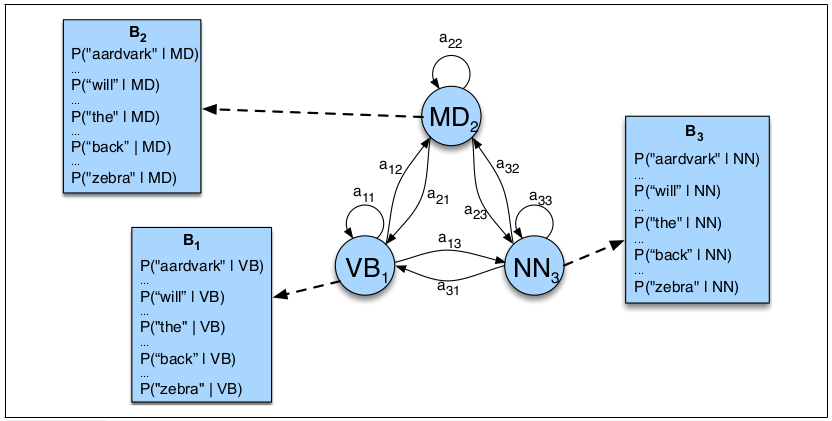

Das Gewicht einer Zustandsfolge mit spezifischen Ausgaben ist das Produkt der involvierten Kanten- und Ausgabengewichte. Das **Ziel (oder "Objective") des HMM-Taggers** ist also, für eine Ausgabe-Kette $w_1 \ldots w_n$ die Zustandsfolge $\hat{t}_{1:n}$ mit dem größten Gewicht zu finden:  

$$\hat{t}_{1:n} \approx \operatorname{arg max}_{t_1 \ldots t_n} \prod^n_{i=1} \overbrace{P(w_i \vert t_i)}^{\text{emission}} \overbrace{P(t_i \vert t_{i-1})}^{\text{transition}}$$

Leider gibt es *sehr* viele mögliche POS-Tag-Folgen für einen Satz mit $n$ Wörtern, nämlich $|\text{Tagset}|^n$. Bei einem Tagset mit 58 POS-Tags (wie bei der Penn Treebank) und einem Satz mit 20 Wörtern sind das also $58^{20}$ Möglichkeiten! Glücklicherweise kann die beste Lösung mit dem [Viterbi-Algorithmus](https://de.wikipedia.org/wiki/Viterbi-Algorithmus) und der Strategie des Dynamic Programming relativ schnell gefunden werden.      

### HMM in NLTK

Ein HMM-POS-Tagger kann in NLTK  mit Hilfe des [HMM-Moduls](https://www.nltk.org/api/nltk.tag.hmm.html?highlight=markov#module-nltk.tag.hmm) erstellt werden. Für Training und Evaluation können wir wieder auf die Golddaten aus dem Brown-Corpus zurückgreifen.

In [24]:
from nltk.tag import hmm
from nltk.corpus import brown

brown_testgold = brown.tagged_sents(
    categories='news', tagset='universal')[:200]
brown_train = brown.tagged_sents(categories='news', tagset='universal')[200:]

hmmtrainer = hmm.HiddenMarkovModelTrainer()
hmmtagger = hmmtrainer.train_supervised(brown_train)

print("Accuracy: ", hmmtagger.accuracy(brown_testgold))

C:\Users\mel\AppData\Local\anaconda3\Lib\site-packages\nltk\tag\hmm.py:336: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])
C:\Users\mel\AppData\Local\anaconda3\Lib\site-packages\nltk\tag\hmm.py:334: RuntimeWarning: overflow encountered in cast
  X[i, j] = self._transitions[si].logprob(self._states[j])
C:\Users\mel\AppData\Local\anaconda3\Lib\site-packages\nltk\tag\hmm.py:364: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])


Accuracy:  0.41246483445141746


Die Accuracy des HMM-Taggers für diese Daten ist nicht gerade beeindruckend, was daran liegt, dass der HMM-Tagger ein großes Problem mit **unbekannten Wörtern** hat. <span style="color:red">(Warum?)</span>  

In [25]:
hmmtagger.tag(['Kim', 'likes', 'chicken', '.'])

[('Kim', 'VERB'), ('likes', 'VERB'), ('chicken', 'VERB'), ('.', 'VERB')]

Man sollte also bei $P(w) = 0$ entweder die Wahrscheinlichkeiten für alle Tags $P(w\vert t)$ anheben ([Laplace Smoothing](https://en.wikipedia.org/wiki/Additive_smoothing)) oder aus der morphologischen Struktur von $w$ die Wahrscheinlichkeit eines Tags abschätzen (siehe z.B. Brants 2000).  

Aber wie schlägt sich denn der HMM-Tagger beim Chunken?

###  <span style="color:red">Aufgaben II: HMM als Chunker</span>

<span style="color:red">A2:</span> Implementieren Sie einen HMM-Chunker mithilfe einer Klasse `HMMChunker` und evaluieren Sie diesen Chunker in gewohnter Weise! Orientieren Sie sich dabei an der Implementierung der [N-Gram-Chunker](#N-Gram-Chunker) oben im Notebook.

In [26]:
# Lösung A2
from nltk.chunk import tree2conlltags, conlltags2tree
class HMMChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        # Konvertierung der training sätze to the format required for the HMM tagger
        train_data = [[(t, c) for w, t, c in nltk.chunk.tree2conlltags(sent)] for sent in train_sents]
        
        # Erstellen und Trainieren des Hidden Markov Model
        self.tagger = hmm.HiddenMarkovModelTrainer().train(train_data)
    
    def parse(self, sentence):
        pos_tags = [pos for (word, pos) in sentence]
        # Markierung der POS-Tags
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word, pos), chunktag) in zip(sentence, chunktags)]
        return conlltags2tree(conlltags)

# Training und Test des HMM Chunkers
hmm_chunker = HMMChunker(conlltrain)
print("HMM Chunker\n----------------")
print(hmm_chunker.accuracy(conlltest))

HMM Chunker
----------------


C:\Users\mel\AppData\Local\anaconda3\Lib\site-packages\nltk\tag\hmm.py:332: RuntimeWarning: overflow encountered in cast
  P[i] = self._priors.logprob(si)


ChunkParse score:
    IOB Accuracy:  90.1%%
    Precision:     83.5%%
    Recall:        86.8%%
    F-Measure:     85.1%%


Was für ein erstaunliches Ergebnis! Können Sie es erklären?

# Appendix: Conditional Random Fields (CRF)

Zwar sind HMM-POS-Tagger etwas mächtiger als N-Gramm-POS-Tagger, was den Zugriff auf den **horizontalen Kontext** eines Zielworts betrifft (der Kontext steht als akkumuliertes Gewicht der zuvor vergebenen Tags abhängig von der Wortform zur Verfügung), aber noch immer eingeschränkt: Es kann nämlich nicht direkt auf beliebige vorangehende oder nachfolgende Wortformen zugegriffen werden. Beim Chunken gibt es außerdem die Einschränkung, dass auf Wortformen überhaupt nicht direkt zugegriffen werden kann, da sich der verfügbare **vertikale Kontext** nur auf Chunk-Tags und POS-Tags erstreckt.

## Wie funktioniert CRF?

Conditional Random Fields (CRF) ist ein Verfahren, das nicht nur besser mit unbekannten Wörtern zurecht kommt, sondern auch deutlich flexibler auf den horizontalen und vertikalen Kontext des Targetworts zugreifen kann. 

Technisch betrachtet gibt es drei Hauptunterschiede zu HMM:
1. CRF ist eine **diskriminatives** Sequenzmodell. Das bedeutet, im Unterschied zu HMM wird der Posterior direkt gelernt: 
$$\overbrace{P(t|w)}^{\text{posterior}}= \frac{P(w|t) P(t)}{P(w)}\text{, wobei $t$ ein Tag und $w$ ein Worttoken wäre.}$$ Ein HMM modelliert dagegen $P(w|t) P(t)$ und zählt daher zu den **generativen** Sequenzmodellen (siehe Jurafsky & Martin 2021: Kapitel 8).  
2. CRF lernt anhand sogenannter **Features**, die gewichtet werden und meist binär sind.
3. Die Gewichte der beobachteten Features werden **summiert**, nicht wie beim HMM die Wahrscheinlichkeiten multipliziert.

Die optimale Tag-Sequenz $\hat{Y}$ für eine Wortkette $X$ der Länge $n$ wird folgendermaßen berechnet, wobei $f_1,\ldots, f_K$ eine Menge von Features mit Gewichten $w_1, \ldots, w_K$ darstellt:
  $$\hat{Y} = \operatorname{arg max}_{Y \in \mathcal{Y}} \sum_{i=1}^{n}\sum_{k=1}^{K} w_k f_k(y_{i-1},y_i,X,i)$$

**Achtung:** Wie beim HMM (erster Ordnung) wird in dieser CRF-Variante (linear-chain CRF) nur das Tag des Zielworttokens und das Tag des vorangehenden Worttokens ($y_{i-1}$, $y_i$) betrachtet! Ein Grund ist, dass dann wieder der Viterbi-Alogorithmus verwendet werden kann, um $\hat{Y}$ effizient zu berechnen.

## Features, Gewichte, Feature-Templates & Feature-Extraktion

Ein **Feature** repräsentiert eine bestimmte Konfiguration von (horizontalen und vertikalen) Kontexteigenschaften eines Target-Worts. Features werden so gewählt, dass sie als **Indiz** für die Korrektheit eines Tag $y_i$ an der Stelle $i$ der Eingabe $X$ dienen. Beispielsweise könnte es ein Feature $f_{103}$ geben ("103" ist zufällig gewählt), das das Indiz repräsentiert, dass ein Worttoken mit der Wortform *the* das Tag DET besitzt: 

$$f_{103}(y_{i-1},y_i,X,i) = \begin{cases}
1 & \text{wenn } y_i = \text{DET} \text{ und } x_i = \mathit{the} \\ 
0 & \text{wenn } \operatorname{not}(y_i = \text{DET}) \text{ und } x_i = \mathit{the}\end{cases}$$

Man beachte, dass beliebige Wortformen links und rechts vom Target als Indiz herangezogen werden können (aber nur das vorangehende Tag), z.B. ein nachfolgender Punkt:

$$f_{104}(y_{i-1},y_i,X,i) = \begin{cases}
1 & \text{wenn } y_i = \text{NN} \text{ und } x_i = \mathit{buy} \text{ und } x_{i+i} = \mathit{.} \\ 
0 & \text{wenn } \operatorname{not}(y_i = \text{NN}) \text{ und } x_i = \mathit{buy} \text{ und } x_{i+i} = \mathit{.}\end{cases}$$

Das **Gewicht** eines Features $f_k$ ergibt sich aus der relativen Anzahl der (definierten) Werte von $f_k$ in einem Lerncorpus, z.B.: 

$$w_k = \frac{\text{count}(f_k = 1)}{\text{count}(f_k = 0)+\text{count}(f_k = 1)}$$

Solche Features von Hand aufzuschreiben, ist offensichtlich sehr mühselig und eintönig. Es gibt allein zehntausende mögliche Features wie $f_{103}$ – da hilft es auch nicht, dass man später die Anzahl der Features anhand der beobachteten Frequenz im Lerncorpus und einer Mindestfrequenz erheblich reduzieren kann (und muss).  

Von Hand spezifiert man daher stattdessen Mengen von Features mittels **Feature-Templates**. Beispielsweise gibt es [in NLTK](https://www.nltk.org/_modules/nltk/tag/crf.html#CRFTagger) standardmäßig die folgenden Templates, die das Unknown-Words-Problem abmildern sollen:
  - Current word
  - Is it capitalized?
  - Does it have punctuation?
  - Does it have a number?
  - Suffixes up to length 3
  
Jedes dieser Templates steht für tausende von Features, wobei unser Feature $f_{103}$ zum Template "Current word" gehört. Die Kompilierung der Features aus Feature-Templates erfolgt automatisch und wird **Feature-Extraktion** genannt. Wir werden in der nächsten Sitzung genauer sehen, wie dies in NLTK umgesetzt ist.    

## Implementierung mit NLTK

Zur Implementierung von CRF-Taggern steht in NLTK das [CRF-Modul](https://www.nltk.org/api/nltk.tag.crf.html?highlight=crf#module-nltk.tag.crf) zu Verfügung. Vor dem Gebrauch muss aber das benötigte Python-Paket installiert sein (Jupyter neu starten nicht vergessen):

    pip install python-crfsuite

Wenden wir den [`CRFTagger`](https://www.nltk.org/api/nltk.tag.crf.html?highlight=crf#nltk.tag.crf.CRFTagger) zuerst auf das POS-Tagging an,  wobei die oben genannten "Einstiegsfeature" verwendet werden.

In [ ]:
from nltk.tag import CRFTagger
from nltk.corpus import brown

ct = CRFTagger()

brown_testgold = brown.tagged_sents(
    categories='news', tagset='universal')[:200]
brown_train = brown.tagged_sents(categories='news', tagset='universal')[200:]

ct.train(brown_train, 'model.crf.tagger')

print("Accuracy: ", ct.accuracy(brown_testgold))

In [ ]:
ct.tag(['Kim', 'likes', 'chicken', '.'])

Dies ist schon mal ein sehr guter Wert an sich und wesentlich besser als die Accuracy des "rohen" HMM-POS-Taggers oben. 

Und so schlägt sich der `CRFTagger` beim Chunking:

In [ ]:
from nltk.tag import CRFTagger

ct = CRFTagger()

train_data = [[(t, c) for w, t, c in nltk.chunk.tree2conlltags(sent)]
              for sent in conlltrain]
test_data = [[(t, c) for w, t, c in nltk.chunk.tree2conlltags(sent)]
             for sent in conlltest]

ct.train(train_data, 'model.crf.tagger')

print("Accuracy: ", ct.accuracy(test_data))

Der `CRFTagger` kann wieder in einen `CRFChunker` eingebettet werden, um das F-Measure bezüglich der Chunks auszugeben.

In [ ]:
class CRFChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        train_data = [[(t, c) for w, t, c in nltk.chunk.tree2conlltags(sent)]
                      for sent in train_sents]
        ct = CRFTagger()
        # model.crf.tagger ist nur ein Platzhalter
        ct.train(train_data, 'model.crf.tagger')
        self.tagger = ct

    def parse(self, sentence):
        pos_tags = [pos for (word, pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word, pos), chunktag)
                     in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)


crf_chunker = CRFChunker(conlltrain)
print(crf_chunker.accuracy(conlltest))

Das F-Measure ist noch einmal 3 Punkte besser als beim HMM-Chunker. Die Konfusionsmatrix zeigt, das die Fehler relativ breit über die Tags verteilt sind. 

In [ ]:
from nltk.metrics import ConfusionMatrix
from nltk import conlltags2tree, tree2conlltags

gold = [chunktag for word, tag, chunktag in conll2000.iob_words()]
test = [chunktag for sent in conll2000.tagged_sents()
        for word, tag, chunktag in tree2conlltags(crf_chunker.parse(sent))]

print(ConfusionMatrix(gold, test).pretty_format(show_percents=True,
      values_in_chart=True, truncate=15, sort_by_count=True))

# Appendix: Klassifiziererbasierte Chunker

Die bisher behandelten Verfahren nutzen ausschließlich POS-Tags für das Chunking. Dies führt zu gewissen Einschränkungen, da die nötigen Informationen nicht immer im POS-Tag verfügbar sind. 

Im NLTK-Buch wird folgendes Beispiel gegeben:

    (3)		
        a.		Joey/NN sold/VBD the/DT farmer/NN rice/NN ./.
        b.		Nick/NN broke/VBD my/DT computer/NN monitor/NN ./.

Der Chunker würde hier auf Grundlage der POS-Tags dieselbe Chunk-Struktur ausgeben. Dabei müssen die Sätze unterschiedlich analysiert werden, nämlich so:

    (3')		
        a.		Joey/NN sold/VBD (NP the/DT farmer/NN) (NP rice/NN) ./.
        b.		Nick/NN broke/VBD (NP my/DT computer/NN monitor/NN) ./.

Dem Chunker fehlt hier die Information, dass *sold* ditransitiv und *broke* transitiv ist. Außerdem ist *computer monitor* eine sogenannte **Kollokation**, d.h. eine geläufige komplexe NP, und *monitor* kann alleine keine NP bilden. 

Um Wortformen zu berücksichtigen, dabei aber nicht in ein Sparse-Data-Problem zu geraten, bieten sich sogenannte klassifiziererbasierte Ansätze an **(dazu mehr in der nächsten Sitzung)**. Im NLTK-Buch ist als Beispiel ein Naive-Bayes-Klassifizierer angegeben, bei dem die Features flexibel erstellt werden können. Hier der nur leicht veränderte Code und die Evaluation:

In [ ]:
class ConsecutiveNPChunkTagger(nltk.TaggerI):
    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history)
                train_set.append((featureset, tag))
                history.append(tag)
        # self.classifier = nltk.MaxentClassifier.train(
        #    train_set, algorithm='megam', trace=0)
        self.classifier = nltk.NaiveBayesClassifier.train(train_set)

    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)


class ConsecutiveNPChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        tagged_sents = [[((w, t), c) for (w, t, c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w, t, c) for ((w, t), c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

In [ ]:
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]
    if i == len(sentence)-1:
        nextword, nextpos = "<END>", "<END>"
    else:
        nextword, nextpos = sentence[i+1]
    return {"pos": pos,
            "word": word,
            "prevpos": prevpos,
            "nextpos": nextpos,
            "prevpos+pos": "%s+%s" % (prevpos, pos),
            "pos+nextpos": "%s+%s" % (pos, nextpos),
            "tags-since-dt": tags_since_dt(sentence, i)}


def tags_since_dt(sentence, i):
    tags = set()
    for word, pos in sentence[:i]:
        if pos == 'DT':
            tags = set()
        else:
            tags.add(pos)
    return '+'.join(sorted(tags))

In [ ]:
chunker = ConsecutiveNPChunker(conlltrain)
print(chunker.accuracy(conlltest))

Wir sehen, dass der Ansatz mit Bayes-Klassifizierer nochmals deutlich bessere Ergebnisse ermöglicht als die einfachen N-Gram-Chunker.

Trotzdem liegt das noch gut 4 %-Punkte unter dem F-Measure der besten Chunker im CoNLL-Shared-Task vor bald 20 Jahre ...

# Literaturangaben

- Brants, Thorsten. 2000. TnT: A Statistical Part-of-Speech Tagger. In Sixth Applied Natural Language Processing Conference, 224–231. Seattle, Washington, USA: Association for Computational Linguistics. https://doi.org/10.3115/974147.974178. https://aclanthology.org/A00-1031.
- Jurafsky, Daniel & James H. Martin. 2021. Speech and Language Processing. An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition. Draft of September 21, 2021. https://web.stanford.edu/jurafsky/slp3/ed3book.pdf.